In [5]:
#importing necessary libraries and packages
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

ModuleNotFoundError: No module named 'keras'

In [2]:
data_labels = pd.read_csv('train_labels.csv')
data_path='train/'
# 0 - negative for tumor tissue, 1 - tumor tissue is present
tot_data_count = len(data_labels)
non_cancer_data_count=data_labels['label'].value_counts()[0]
has_cancer_data_count=data_labels['label'].value_counts()[1]

print('Distribution of cancer data to non cancer data : ',(has_cancer_data_count*100/tot_data_count),':',(non_cancer_data_count*100/tot_data_count))
data_labels.head()


Distribution of cancer data to non cancer data :  40.503124644926714 : 59.496875355073286


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<h3>Visual Representation of the data  for better understading</h3>

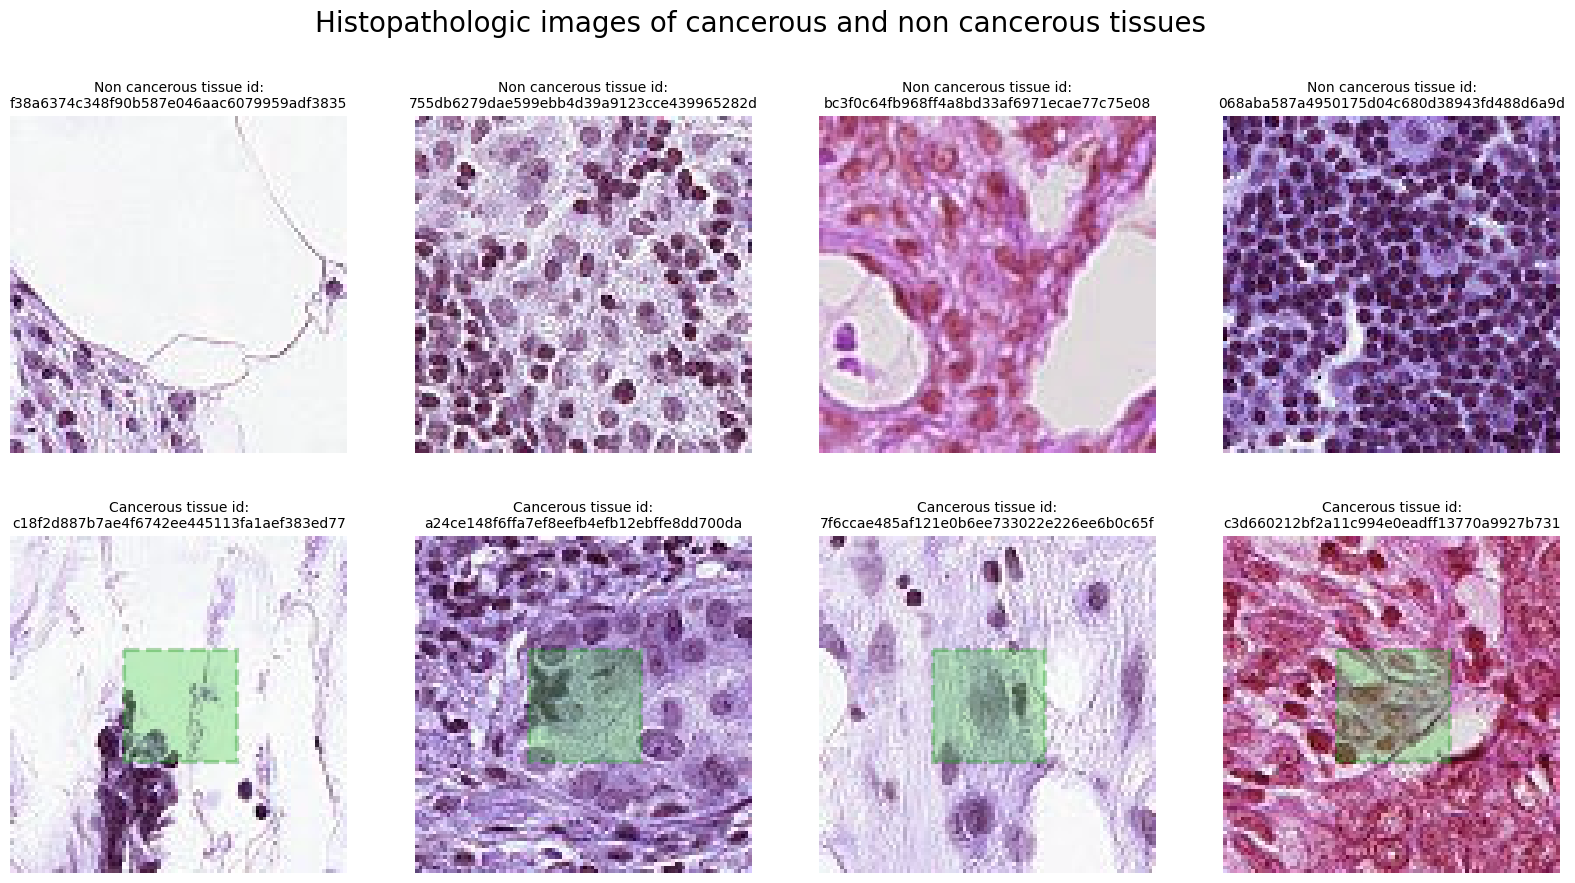

In [3]:
fig, fig_axis=plt.subplots(2,4,figsize=(20,10))
fig.suptitle('Histopathologic images of cancerous and non cancerous tissues',fontsize=20)
# non cancerouus tissue
for ind, img_id in enumerate(data_labels[data_labels['label']==0]['id'][:4]):
    img=cv2.imread(os.path.join(data_path,'{}.tif'.format(img_id)))
    fig_axis[0,ind].imshow(img)
    fig_axis[0,ind].axis('off')
    fig_axis[0,ind].set_title('Non cancerous tissue id:\n'+img_id,fontsize=10)
# cancerous tissue with patch showing the region of interest
for ind, img_id in enumerate(data_labels[data_labels['label']==1]['id'][:4]):
    img=cv2.imread(os.path.join(data_path,'{}.tif'.format(img_id)))
    fig_axis[1,ind].imshow(img)
    fig_axis[1,ind].axis('off')
    fig_axis[1,ind].set_title('Cancerous tissue id:\n'+img_id,fontsize=10)
    # add a translucent light green colored rectangular area over the central 32x32 region
    rect = patches.Rectangle((32,32),32,32,linewidth=3,edgecolor='green',facecolor='limegreen',linestyle='dashed', alpha=0.3)
    fig_axis[1,ind].add_patch(rect)

plt.show()


In [4]:
#randomly selecting 5000 images of each label to be used as the final dataset
non_cancer_data=data_labels[data_labels['label']==0].sample(n=5000,random_state=42)
has_cancer_data=data_labels[data_labels['label']==1].sample(n=5000,random_state=42)
#creating train and test sets from above data with 80:20 split
train_data=pd.concat([non_cancer_data[:4000],has_cancer_data[:4000]],axis=0)
test_data=pd.concat([non_cancer_data[4000:],has_cancer_data[4000:]],axis=0)
#shuffling the train and test data
train_data=shuffle(train_data).reset_index(drop=True)
test_data=shuffle(test_data).reset_index(drop=True)
#saving the train and test data to csv files
train_data.to_csv('train_data.csv',index=False)
test_data.to_csv('test_data.csv',index=False)
print('Train data shape: ',train_data.shape)
print('Test data shape: ',test_data.shape)
train_data


Train data shape:  (8000, 2)
Test data shape:  (2000, 2)


,id,label
0,65a6219d8609b87bac2fc717630dd39da4ba593c,1
1,60d81ca9c689b5b48a7fb02bb745e86844e049c6,1
2,9bb477bde84e7f0bbc96e208a494d7af0ee9a999,1
3,e1dad6be7d6f28c1579417db9870de6bd7efbb6f,1
4,319bffb5e9476414bfa8550a8b8ddf9cf1dc853a,0
...,...,...
7995,58b4c179d38e55002a9311fa1d56bc08685ba6d1,1
7996,28b50ddd6960c9f0610baf7417c5128e2f47bfca,1
7997,ac6fe4954c227690504299ab6db36499ceeebe01,0
7998,1ba484ccb82ad5cbcf9467a15f467b03f3505547,1


In [5]:
# adding a path column in the dataset so that it is easier to load the images
train_data['path']=train_data['id'].map(lambda x: os.path.join(data_path,'{}.tif'.format(x)))
test_data['path']=test_data['id'].map(lambda x: os.path.join(data_path,'{}.tif'.format(x)))
train_data.head()
#making path the first column in the dataframe
train_data=train_data[['path','id','label']]
test_data=test_data[['path','id','label']]
train_data.head()

,path,id,label
0,train/65a6219d8609b87bac2fc717630dd39da4ba593c...,65a6219d8609b87bac2fc717630dd39da4ba593c,1
1,train/60d81ca9c689b5b48a7fb02bb745e86844e049c6...,60d81ca9c689b5b48a7fb02bb745e86844e049c6,1
2,train/9bb477bde84e7f0bbc96e208a494d7af0ee9a999...,9bb477bde84e7f0bbc96e208a494d7af0ee9a999,1
3,train/e1dad6be7d6f28c1579417db9870de6bd7efbb6f...,e1dad6be7d6f28c1579417db9870de6bd7efbb6f,1
4,train/319bffb5e9476414bfa8550a8b8ddf9cf1dc853a...,319bffb5e9476414bfa8550a8b8ddf9cf1dc853a,0


In [6]:
#reading the train images as numpy arrays
train_img=[]
for img_path in tqdm_notebook(train_data['path']):
    img=cv2.imread(img_path)
    train_img.append(img)
train_img=np.array(train_img)
#train img labels np arrary 
train_label=np.array(train_data['label'])
print('Train data shape: ',train_img.shape)
print('Train label shape: ',train_label.shape)

C:\Users\hp\AppData\Local\Temp\ipykernel_9120\305577981.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_path in tqdm_notebook(train_data['path']):


  0%|          | 0/8000 [00:00<?, ?it/s]

Train data shape:  (8000, 96, 96, 3)
Train label shape:  (8000,)


In [7]:
#reading the train images as numpy arrays
test_img=[]
#reading the test images as numpy arrays
for img_path in tqdm_notebook(test_data['path']):
    img=cv2.imread(img_path)
    test_img.append(img)
test_img=np.array(test_img)
#test img labels np arrary 
test_label=np.array(test_data['label'])
print('Test data shape: ',test_img.shape)
print('Test label shape: ',test_label.shape)


C:\Users\hp\AppData\Local\Temp\ipykernel_9120\3037224311.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_path in tqdm_notebook(test_data['path']):


  0%|          | 0/2000 [00:00<?, ?it/s]

Test data shape:  (2000, 96, 96, 3)
Test label shape:  (2000,)


The code in this cell visualizes the distribution of pixel values in the cancerous and non-cancerous images. It creates a histogram for each channel of the image (red, green, and blue) as well as for all channels combined. The histograms are plotted side by side for easy comparison.

The insights we can gather from this visualization are:
- The pixel values for cancerous and non-cancerous images are distributed differently.
- The blue channel seems to have the most variation in pixel values for both cancerous and non-cancerous images.
- The histograms for the red and green channels are similar for both cancerous and non-cancerous images.
- The histograms for all channels combined show a clear difference between cancerous and non-cancerous images.

These insights can help us in our project by providing a better understanding of the data we are working with. We can use this information to develop better image processing techniques and to identify features that are important for distinguishing between cancerous and non-cancerous images.

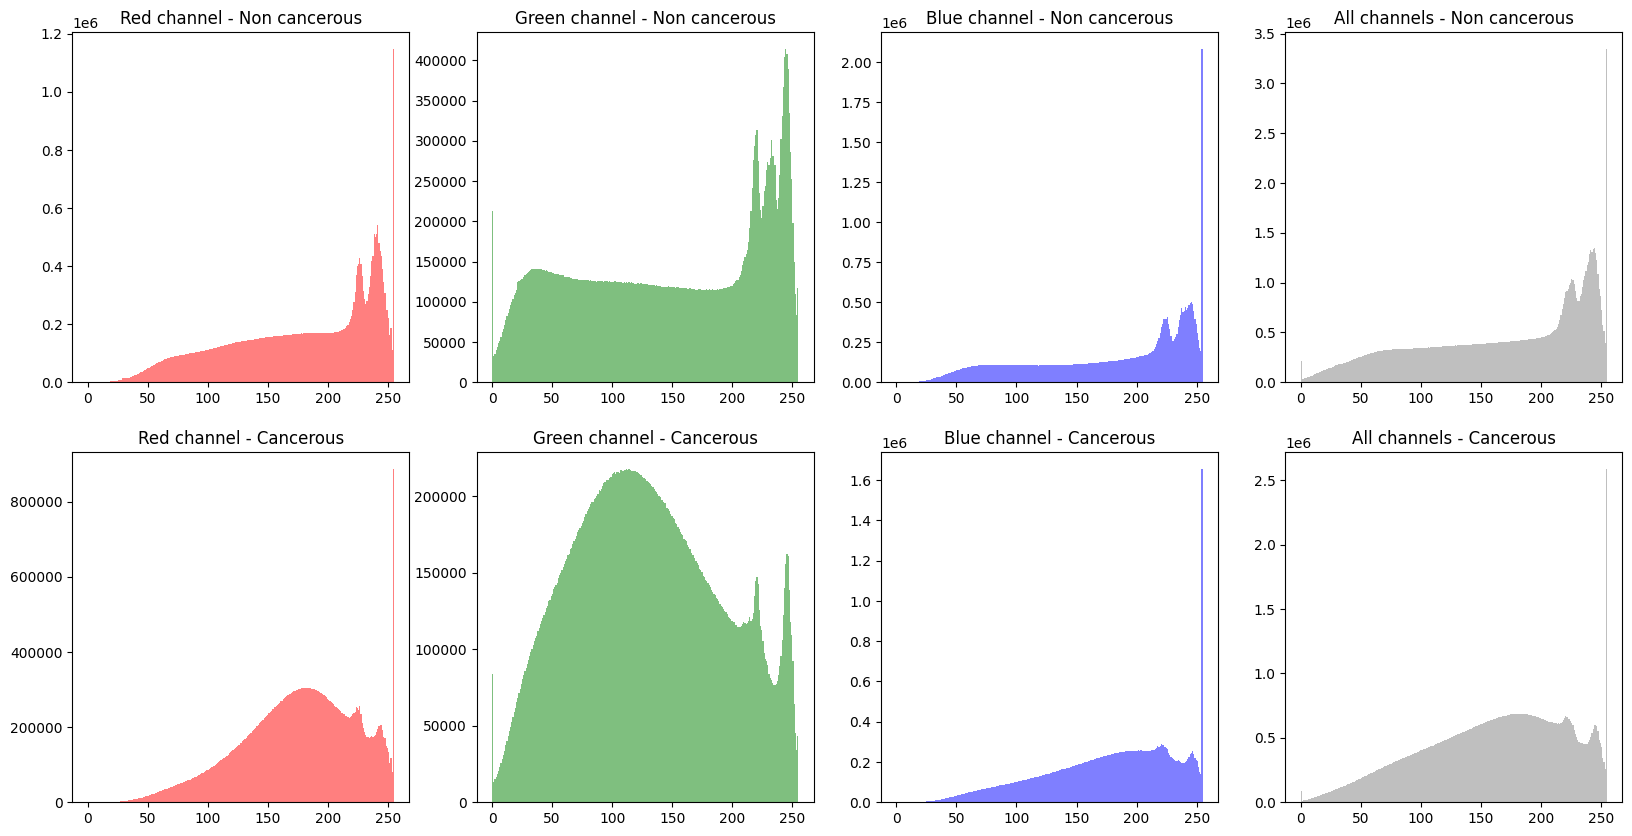

In [8]:
# visualizing the distribution of pixel values in the cancerous and non cancerous images
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs[0, 0].hist(train_img[train_label==0][:, :, :, 0].ravel(), bins=256, color='red', alpha=0.5)
axs[0, 0].set_title('Red channel - Non cancerous')
axs[0, 1].hist(train_img[train_label==0][:, :, :, 1].ravel(), bins=256, color='green', alpha=0.5)
axs[0, 1].set_title('Green channel - Non cancerous')
axs[0, 2].hist(train_img[train_label==0][:, :, :, 2].ravel(), bins=256, color='blue', alpha=0.5)
axs[0, 2].set_title('Blue channel - Non cancerous')
axs[0, 3].hist(train_img[train_label==0].ravel(), bins=256, color='gray', alpha=0.5)
axs[0, 3].set_title('All channels - Non cancerous')

axs[1, 0].hist(train_img[train_label==1][:, :, :, 0].ravel(), bins=256, color='red', alpha=0.5)
axs[1, 0].set_title('Red channel - Cancerous')
axs[1, 1].hist(train_img[train_label==1][:, :, :, 1].ravel(), bins=256, color='green', alpha=0.5)
axs[1, 1].set_title('Green channel - Cancerous')
axs[1, 2].hist(train_img[train_label==1][:, :, :, 2].ravel(), bins=256, color='blue', alpha=0.5)
axs[1, 2].set_title('Blue channel - Cancerous')
axs[1, 3].hist(train_img[train_label==1].ravel(), bins=256, color='gray', alpha=0.5)
axs[1, 3].set_title('All channels - Cancerous')
plt.show()


The code in this cell calculates the mean pixel value for each image in the training dataset, separately for cancerous and non-cancerous images. It then plots a histogram of the mean brightness values for both types of images side by side for easy comparison.

The insights we can gather from this visualization are:
- The mean brightness values for cancerous and non-cancerous images are distributed differently.
- The mean brightness values for non-cancerous images are generally higher than those for cancerous images.
- The histograms for non-cancerous images are more spread out than those for cancerous images.

These insights can help us in our project by providing a better understanding of the data we are working with. We can use this information to develop better image processing techniques and to identify features that are important for distinguishing between cancerous and non-cancerous images. For example, we could use the mean brightness value as a feature in a machine learning model to predict whether an image is cancerous or not.

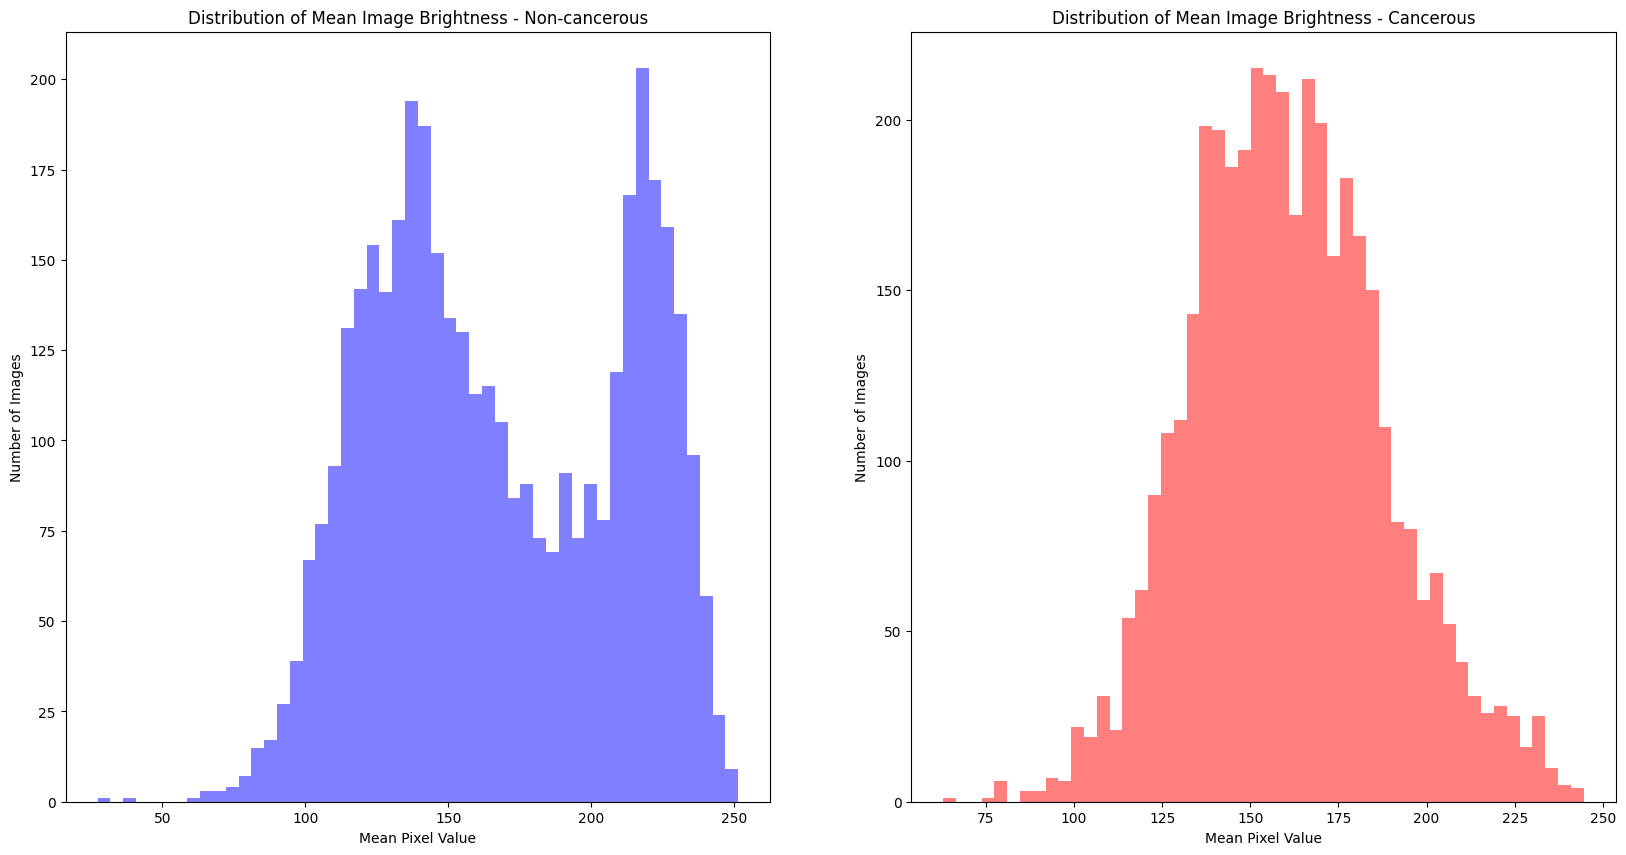

In [9]:
# calculate mean pixel value for each image
mean_brightness_cancerous = np.mean(train_img[train_label==1], axis=(1,2,3))
mean_brightness_non_cancerous = np.mean(train_img[train_label==0], axis=(1,2,3))

# plot histogram of mean brightness values for cancerous and non-cancerous images
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].hist(mean_brightness_non_cancerous, bins=50, color='blue', alpha=0.5)
axs[0].set_title('Distribution of Mean Image Brightness - Non-cancerous')
axs[0].set_xlabel('Mean Pixel Value')
axs[0].set_ylabel('Number of Images')

axs[1].hist(mean_brightness_cancerous, bins=50, color='red', alpha=0.5)
axs[1].set_title('Distribution of Mean Image Brightness - Cancerous')
axs[1].set_xlabel('Mean Pixel Value')
axs[1].set_ylabel('Number of Images')

plt.show()

In [10]:
# set the parameters for the model to be used
# kernal_size: sets the size of the convolutional kernel
# pool_size: sets the size of the pooling window
# first_filters: sets the number of filters in the first convolutional layer
# second_filters: sets the number of filters in the second convolutional layer
# third_filters: sets the number of filters in the third convolutional layer
kernal_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used to prevent overfitting
dropout_conv = 0.3
dropout_dense = 0.5

In [3]:
# initialize the model
model = Sequential()

# add first convolutional block
model.add(Conv2D(first_filters, kernal_size, activation='relu', input_shape=(96, 96, 3)))
model.add(BatchNormalization())
model.add(Conv2D(first_filters, kernal_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# add second convolutional block
model.add(Conv2D(second_filters, kernal_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(second_filters, kernal_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# add third convolutional block
model.add(Conv2D(third_filters, kernal_size, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(third_filters, kernal_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(dropout_conv))

# add flatten layer
model.add(Flatten())

# add dense layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation='sigmoid'))


NameError: name 'Sequential' is not defined

In [4]:
#print model summary
model.summary()


NameError: name 'model' is not defined

In [13]:
# compile the model
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    

In [14]:
# normalize pixel values between 0 and 1
train_img = train_img.astype('float32') / 255.0
#do the same for test data
test_img = test_img.astype('float32') / 255.0

In [15]:
#traininig the model
history = model.fit(train_img, train_label, batch_size=50, epochs=15, validation_split=0.2)

Epoch 1/15
128/128 [==============================] - 13s 67ms/step - loss: 0.5799 - accuracy: 0.7362 - val_loss: 2.3997 - val_accuracy: 0.5362
Epoch 2/15
128/128 [==============================] - 8s 64ms/step - loss: 0.5112 - accuracy: 0.7773 - val_loss: 3.5343 - val_accuracy: 0.5444
Epoch 3/15
128/128 [==============================] - 8s 64ms/step - loss: 0.4566 - accuracy: 0.7970 - val_loss: 1.7780 - val_accuracy: 0.6075
Epoch 4/15
128/128 [==============================] - 8s 64ms/step - loss: 0.4170 - accuracy: 0.8194 - val_loss: 0.7330 - val_accuracy: 0.7081
Epoch 5/15
128/128 [==============================] - 8s 64ms/step - loss: 0.4086 - accuracy: 0.8255 - val_loss: 0.5150 - val_accuracy: 0.7619
Epoch 6/15
128/128 [==============================] - 8s 65ms/step - loss: 0.3754 - accuracy: 0.8380 - val_loss: 0.6447 - val_accuracy: 0.7469
Epoch 7/15
128/128 [==============================] - 8s 65ms/step - loss: 0.3643 - accuracy: 0.8411 - val_loss: 0.4794 - val_accuracy: 0.794

In [18]:
#evaluate the model on test data
score = model.evaluate(test_img, test_label, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.45302310585975647
Test accuracy: 0.828000009059906


The code in this cell plots the training and validation loss and accuracy for a deep learning model that was trained to detect cancerous cells in histopathologic images. The insights we can gather from this visualization are:

- The training loss decreases steadily over time, indicating that the model is learning from the training data.
- The validation loss also decreases initially, but then starts to level off or even increase slightly, indicating that the model may be overfitting to the training data.
- The training accuracy increases steadily over time, indicating that the model is getting better at predicting the correct labels for the training data.
- The validation accuracy also increases initially, but then starts to level off or even decrease slightly, indicating that the model may be overfitting to the training data.

Based on these insights, we can conclude that the model is performing reasonably well on the training data, but may not generalize well to new, unseen data. To improve the model's performance, we could try using techniques such as regularization, data augmentation, or transfer learning. We could also try adjusting the hyperparameters of the model, such as the learning rate or the number of layers, to see if that improves performance.

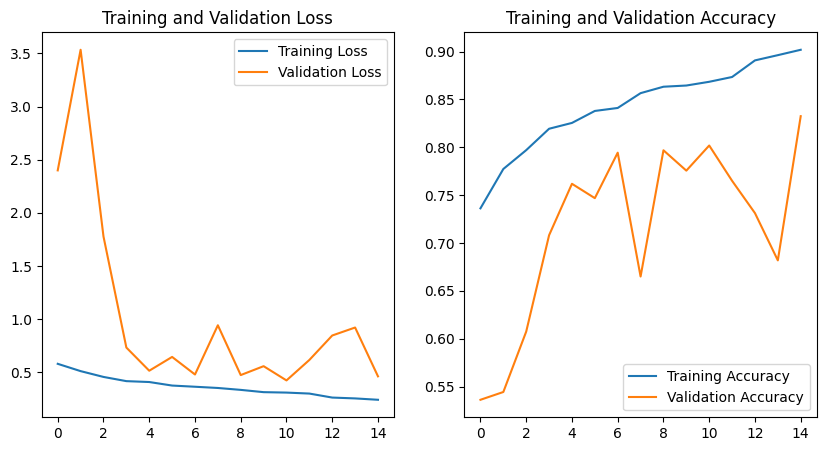

In [27]:
# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss') # plot the training loss
plt.plot(history.history['val_loss'], label='Validation Loss') # plot the validation loss
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') # set the title of the plot

# plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy') # plot the training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # plot the validation accuracy
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy') # set the title of the plot
plt.show() # display the plot


In [31]:
# make predictions on test data
y_pred = model.predict(test_img)

# convert predictions to binary values
y_pred = np.round(y_pred)

63/63 [==============================] - 1s 10ms/step


In [32]:
from sklearn.metrics import roc_auc_score

# calculate AUC score
auc_score = roc_auc_score(test_label, y_pred)

print('AUC Score:', auc_score)

AUC Score: 0.828


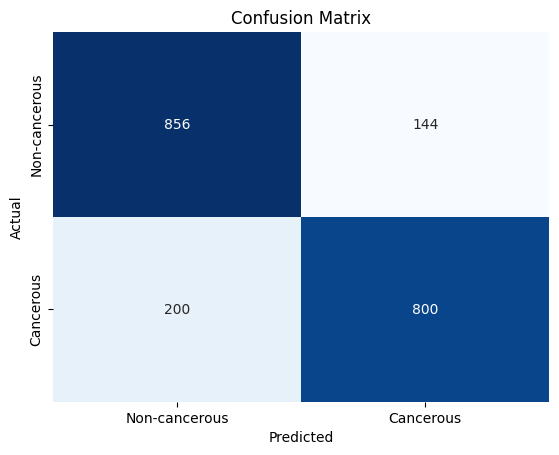

In [39]:
#create confusion matrix
cm = confusion_matrix(test_label, y_pred, labels=[0, 1])
#plot confusion matrix
plt.figure()
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-cancerous', 'Cancerous'])
plt.yticks([0.5, 1.5], ['Non-cancerous', 'Cancerous'])
plt.show()


In [40]:
from sklearn.metrics import classification_report

# generate classification report
report = classification_report(test_label, y_pred)

# print the report
print(report)


              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1000
           1       0.85      0.80      0.82      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [48]:
# randomly selecting 20000 images of each label to be used as the final dataset
non_cancer_data = data_labels[data_labels['label'] == 0].sample(n=10000, random_state=42)
has_cancer_data = data_labels[data_labels['label'] == 1].sample(n=10000, random_state=42)

# creating train and test sets from above data with 80:20 split
train_data = pd.concat([non_cancer_data[:7500], has_cancer_data[:7500]], axis=0)
test_data = pd.concat([non_cancer_data[7500:], has_cancer_data[7500:]], axis=0)

# shuffling the train and test data
train_data = shuffle(train_data).reset_index(drop=True)
test_data = shuffle(test_data).reset_index(drop=True)

print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

# adding a path column in the dataset so that it is easier to load the images
train_data['path'] = train_data['id'].map(lambda x: os.path.join(data_path, '{}.tif'.format(x)))
test_data['path'] = test_data['id'].map(lambda x: os.path.join(data_path, '{}.tif'.format(x)))

# making path the first column in the dataframe
train_data = train_data[['path', 'id', 'label']]
test_data = test_data[['path', 'id', 'label']]

# reading the train images as numpy arrays
train_img = []
for img_path in train_data['path']:
    img = cv2.imread(img_path)
    train_img.append(img)
train_img = np.array(train_img)

# train img labels np arrary
train_label = np.array(train_data['label'])

print('Train image shape: ', train_img.shape)
print('Train label shape: ', train_label.shape)

# reading the test images as numpy arrays
test_img = []
for img_path in test_data['path']:
    img = cv2.imread(img_path)
    test_img.append(img)
test_img = np.array(test_img)

# test img labels np arrary
test_label = np.array(test_data['label'])

print('Test img shape: ', test_img.shape)
print('Test label shape: ', test_label.shape)


Train data shape:  (15000, 2)
Test data shape:  (5000, 2)
Train image shape:  (15000, 96, 96, 3)
Train label shape:  (15000,)
Test img shape:  (5000, 96, 96, 3)
Test label shape:  (5000,)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of the ImageDataGenerator class
datagen = ImageDataGenerator(
    rotation_range=20, # randomly rotate images by up to 20 degrees
    width_shift_range=0.1, # randomly shift images horizontally by up to 10%
    height_shift_range=0.1, # randomly shift images vertically by up to 10%
    zoom_range=0.1, # randomly zoom images by up to 10%
    horizontal_flip=True, # randomly flip images horizontally
    fill_mode='nearest' # fill any gaps created by the above transformations with the nearest pixel value
)

# fit the ImageDataGenerator to the training data
datagen.fit(train_img)
# set the batch size and number of epochs
batch_size = 32
epochs = 10

# create a generator for the augmented training data
train_generator = datagen.flow(train_img, train_label, batch_size=batch_size)

# train the model using the augmented data
history = model.fit(train_generator, epochs=epochs, validation_data=(test_img, test_label))
